# Part 3: Model Comparison with SVM

In this notebook, you will compare two different multi-class SVM implementations on the Maine bills dataset.

In [1]:
# Import necessary libraries for data processing and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Import Support Vector Machine tools
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
# Import evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load features and target from JSON files
X_df = pd.read_json('data/X.json')
y_df = pd.read_json('data/y_multi.json')

# Extract title embeddings and committee ID targets into numpy arrays
X = np.array(X_df['title_embedding'].tolist())
y = y_df['committee_id'].values

# Split the data 80% for training and 20% for testing (stratifying to balance classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=6140, stratify=y
)

In [ ]:
# Build a pipeline to scale data and then apply One-Vs-Rest classification using a linear SVM
#Assembling the pipeline
pipeline_ovr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', OneVsRestClassifier(SVC(kernel='linear', random_state=42)))
])
# Training the One-Vs-Rest pipeline on the training data
pipeline_ovr.fit(X_train, y_train)

# Building a second pipeline for One-Vs-One classification
pipeline_ovo = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', OneVsOneClassifier(SVC(kernel='linear', random_state=42)))
])
# Training the One-Vs-One pipeline
pipeline_ovo.fit(X_train, y_train)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,SVC(kernel='l...ndom_state=42)
,n_jobs,None
,C,1.0
,kernel,'linear'


=== OneVsRestClassifier Performance ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.75      1.00      0.86         3
           2       0.36      0.28      0.31        18
           3       0.33      0.37      0.35        19
           4       0.36      0.33      0.35        12
           5       0.54      0.70      0.61        10
           6       0.19      0.19      0.19        21
           7       0.45      0.47      0.46        30
           8       0.33      0.35      0.34        20
           9       0.60      0.43      0.50         7
          10       0.41      0.48      0.44        33
          11       0.38      0.45      0.42        11
          12       0.50      0.75      0.60         4
          13       0.20      0.12      0.15        16
          14       0.72      0.62      0.67        21
          15       0.61      0.79      0.69        14
          16       0.46      0.46      0.

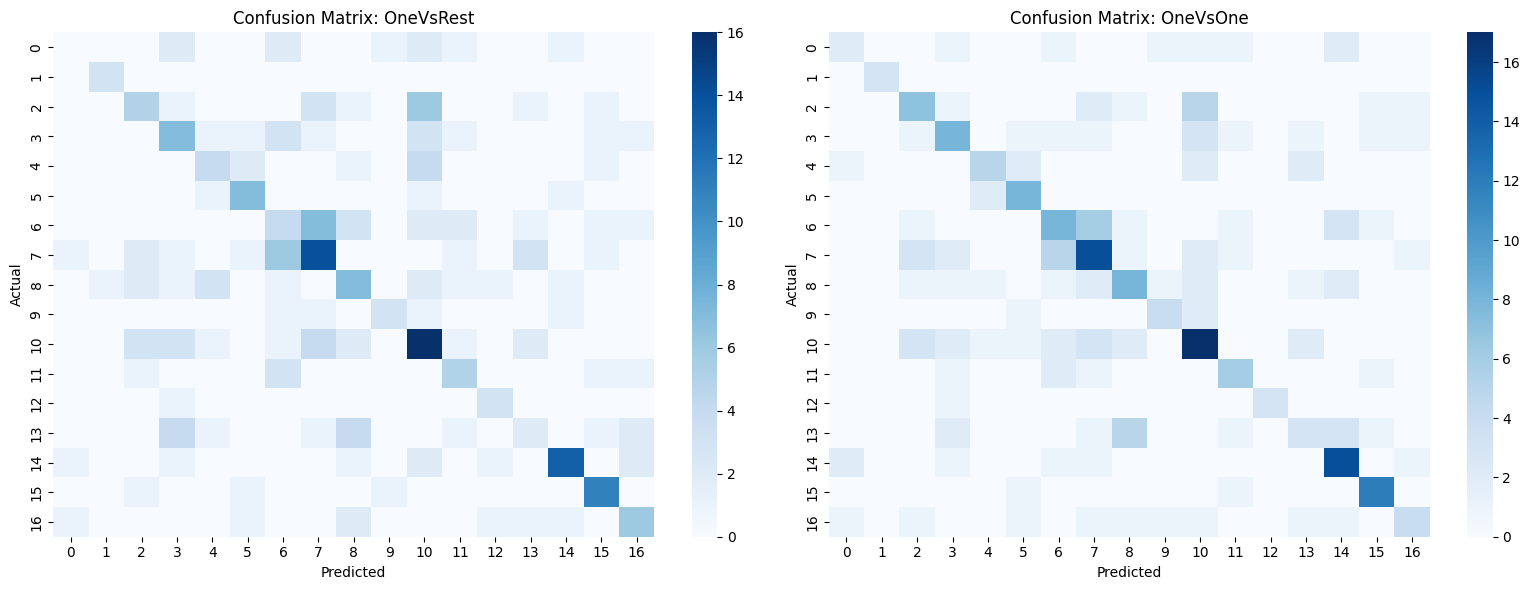

In [ ]:
# Generating predictions from both of our pipelines on the unseen test set
ovr_preds = pipeline_ovr.predict(X_test)
ovo_preds = pipeline_ovo.predict(X_test)

# Printing a classification report (precision, recall, f1) for One-Vs-Rest
print('=== OneVsRestClassifier Performance ===')
print(classification_report(y_test, ovr_preds, zero_division=0))

# Printing a classification report for One-Vs-One
print('\n=== OneVsOneClassifier Performance ===')
print(classification_report(y_test, ovo_preds, zero_division=0))

# Creating a figure side-by-side to plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Generating and display a heatmap of the confusion matrix for OVR
sns.heatmap(confusion_matrix(y_test, ovr_preds), annot=False, cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix: OneVsRest')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Generating and display a heatmap of the confusion matrix for OVO
sns.heatmap(confusion_matrix(y_test, ovo_preds), annot=False, cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix: OneVsOne')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Displaying our final plots
plt.tight_layout()
plt.show()

Answer the following questions:

1. Which multiclass SVM implementation (OneVsRestClassifier or OneVsOneClassifier) performed better on the test set? Why do you think that is the case?
2. How does the choice of kernel affect the performance of the SVM model? What other kernels might be worth trying for this dataset?
3. Do you think SVM is a good model for this dataset? Why or why not? What other models might be worth trying?

**Answers:**

1. The performances are nearly identical, but OneVsOneClassifier (OvO) typically performs slightly better and is less prone to extreme bias in datasets like this.  Because our dataset is heavily imbalanced, the One-Vs-Rest (OvR) strategy struggles. When an OvR mini-robot looks at a rare committee vs The Rest, it is overwhelmed by the massive size of The Rest and often just blindly guesses NO to play it safe. One-Vs-One solves this by only comparing two specific committees at a time, which levels the playing field and forces  to actually look at the subtle differences between those two specific topics rather than being drowned out by the majority.

2. The choice of kernel is critical because it defines the shape of the decision boundary. A linear kernel expects the classes to be separable by a flat hyperplane. However, embedded text namespaces often feature non-linear semantic relationships. An RBF (Radial Basis Function) kernel or a Polynomial kernel might learn much better non-linear boundaries in this dataset, and are definitely worth trying to improve accuracy.

3. SVM is a decent baseline model especially for high-dimensional feature spaces like text embeddings. However, due to the overlapping semantic structures, advanced tree-based ensemble methods such as XGBoost or Random Forest, or simple neural networks (like a multi-layer perceptron/dense-network) could handle non-linear boundaries much faster and implicitly manage multi-class tasks better than building OVO or OVR pipelines through SVMs.